# Predicting blood culture outcomes in the emergency department of a US-based hospital with deep learning
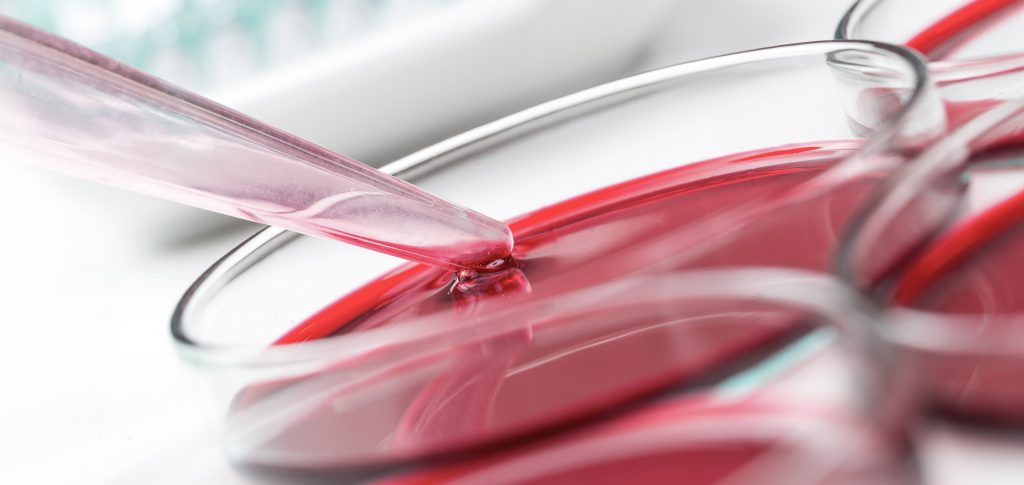

For the final project of the DTSA-5511: Introduction to Deep Learning, we are tasked with creating a deep learning model to solve a problem. In my daily work as a phycisian-researcher, I try to optimize the use of diagnostic testing for infectious diseases. This final project combines those fields.

In emergency departments (EDs), physicians order blood culture tests for most patients suspected of having an infection. A blood culture can detect a bacterium circulating in the bloodstream, which is a severe, but treatable condition. Since physicians are affraid of missing these infections, blood cultures are ordered even in patients with a very low risk of having such a bacterial bloodstream infection. Therefore, the yield of this diagnostic test is only about 5%, of which about 50% can be contaminated. Not only are we wasting precious resources through this practice, the patients with false-positive cultures usually undergo additional diagnostic testing, receive unnecessary treatments with antibiotics, and have a prolonged hospital stay. 

With this project, I aim to create a deep learning model to try and estimate the chance that a certain blood culture will be positive. Instead of waiting 24-72 hours for blood culture results, the physicians could use this prediction model to estimate the risk of a positive blood culture, and withhold testing in low risk patients. This could potentially save costs and harmful effects of false positive (contaminated) cultures that should not have been performed in the first place. For my work as a researcher (PhD student), I have previously created such a model using other supervised learning techniques (logistic regression, random forests, and gradient boosting). After finishing the DTSA 11 course, I think we may be able to improve upon those performances using deep learning.

For this project, I will use data that is available to all researchers through the MIMIC-IV-ED dataset (https://physionet.org/content/mimic-iv-ed/2.0/). This dataset contains anonymized data on all patients who stayed in the ED of the Beth Israel Deaconess Medical Center in Boston between 2011-2019. For this project, I downloaded a subset of patients in whom a blood culture analysis was performed during their ED visit. I used the following parameters: age, sex, laboratory results, and vital sign measurements, all collected during the ED stay. The dataset also contained a column with the "outcome" of the blood culture, which is 0 when turned out to be negative (or was false positive), and 1 when it turned out to be a true-positive.

## Importing the data
Let's start by importing the data from a csv file and having a quick glance at the information.

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
dataset = pd.read_csv("MIMIC.csv")                                 
dataset.describe()

,outcome,Age,Sex,Alkaline_phosphatase,Basophils,Bilirubin,Creatinine,CRP,Eosinophils,Gamma_GT,Glucose,Hemoglobin,Hematocrit,Leukocytes,Lymfocytes,Monocytes,Neutrophils,Potassium,Sodium,Thrombocytes,Urea,Heartrate,Systolic_blood_pressure,Diastolic_blood_pressure,Temperature,Respiratory_rate,Saturation
count,27706.000000,27706.000000,27706.000000,12883.000000,13439.000000,12611.000000,26356.000000,2064.000000,12413.000000,123.000000,26381.000000,25301.000000,25256.000000,25165.000000,15111.000000,15126.000000,15208.000000,26324.000000,26357.000000,25181.000000,26280.000000,27698.000000,27681.000000,27547.000000,26830.000000,27672.000000,27294.000000
mean,0.054356,60.143326,0.508013,139.934888,0.042768,24.731326,133.233087,73.607892,0.164858,295.504065,7.736997,6.964217,0.345257,10.474578,1.437572,0.805779,8.000753,4.342884,137.323007,237.569787,4.242636,86.093240,126.797158,70.354359,36.930090,18.355850,97.520184
std,0.226724,17.515691,0.499945,153.770408,0.080180,54.550501,153.717223,76.255879,0.392091,473.891206,4.654847,1.423906,0.065358,6.018630,1.105829,0.593879,5.468961,0.823697,5.123344,122.286517,3.597638,16.458938,20.155770,13.055986,0.586387,2.944234,2.352909
min,0.000000,18.000000,0.000000,12.000000,0.003333,2.565000,17.680000,0.100000,0.002500,5.000000,1.387500,1.512713,0.083000,0.100000,0.020000,0.010000,0.005000,2.000000,102.000000,5.000000,0.582750,16.000000,54.500000,40.000000,28.074074,8.000000,16.000000
25%,0.000000,49.000000,0.000000,71.000000,0.020000,5.130000,61.880000,11.000000,0.040000,45.500000,5.309500,5.957760,0.300000,6.600000,0.770000,0.490000,4.340000,3.800000,135.000000,160.000000,1.998000,74.333333,112.333300,61.500000,36.611111,16.600000,96.471362
50%,0.000000,61.000000,1.000000,96.000000,0.030000,10.260000,88.400000,47.700000,0.100000,133.000000,6.271500,7.012780,0.349000,9.250000,1.240000,0.710000,6.730000,4.200000,138.000000,222.000000,2.997000,84.666667,125.000000,69.666667,36.822222,17.750000,98.000000
75%,0.000000,73.000000,1.000000,144.000000,0.050000,18.810000,132.600000,112.750000,0.200000,314.000000,8.241750,7.943680,0.391000,12.900000,1.862500,0.990000,10.200000,4.700000,140.000000,293.000000,4.995000,96.428570,139.000000,78.000000,37.138889,19.200000,99.000000
max,1.000000,91.000000,1.000000,2416.000000,4.070000,908.010000,2042.040000,586.200000,21.740000,3714.000000,91.658250,12.412000,0.649000,59.700000,21.740000,14.450000,59.960000,10.000000,180.000000,1296.000000,43.456500,183.500000,233.750000,248.250000,42.331250,48.800000,100.000000


## Exploratory Data Analysis (EDA) and data cleaning
It seems that we have over 27000 unique patient visits to work with. Some of the columns have missing data, let's have a closer look at the percentages of data missing in the various columns:

In [2]:
# Calculate the maximum percentage of missing values across all features
percent_imputed = dataset.isnull().mean().max().round(4) * 100

# Calculate the percentage of missing values for each feature, sort in descending order. Don't include the outcome.
missing_dataframe = (dataset.isnull().sum() / dataset.shape[0] * 100).round(2)
missing_dataframe = missing_dataframe.sort_values(ascending=False).head(24).to_frame(name="Percentage missing")

# Add a row to the DataFrame with the mean percentage of missing values across all features
missing_dataframe.loc["Total percentage imputed"] = round(missing_dataframe.mean(), 2)

# Display the DataFrame
print("Percentage of missing values for all features (and the mean across all features):\n")
print(missing_dataframe.to_string(formatters={"Percentage missing": "{:.1f}%".format}))


Percentage of missing values for all features (and the mean across all features):

                         Percentage missing
Gamma_GT                              99.6%
CRP                                   92.5%
Eosinophils                           55.2%
Bilirubin                             54.5%
Alkaline_phosphatase                  53.5%
Basophils                             51.5%
Lymfocytes                            45.5%
Monocytes                             45.4%
Neutrophils                           45.1%
Leukocytes                             9.2%
Thrombocytes                           9.1%
Hematocrit                             8.8%
Hemoglobin                             8.7%
Urea                                   5.2%
Potassium                              5.0%
Creatinine                             4.9%
Sodium                                 4.9%
Glucose                                4.8%
Temperature                            3.2%
Saturation                           

We can see that most of the features are available for at least half of the patients, which is a pretty high percentage for the nature of this data. However, Gamma_GT and CRP laboratory values are missing for most patients. Given these high numbers of missing values, we will drop these columns from the dataframe.

In [3]:
dataset = dataset.drop(["Gamma_GT", "CRP"], axis=1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27706 entries, 0 to 27705
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   outcome                   27706 non-null  int64  
 1   Age                       27706 non-null  int64  
 2   Sex                       27706 non-null  int64  
 3   Alkaline_phosphatase      12883 non-null  float64
 4   Basophils                 13439 non-null  float64
 5   Bilirubin                 12611 non-null  float64
 6   Creatinine                26356 non-null  float64
 7   Eosinophils               12413 non-null  float64
 8   Glucose                   26381 non-null  float64
 9   Hemoglobin                25301 non-null  float64
 10  Hematocrit                25256 non-null  float64
 11  Leukocytes                25165 non-null  float64
 12  Lymfocytes                15111 non-null  float64
 13  Monocytes                 15126 non-null  float64
 14  Neutro

Now that we have all the features we would like, let's have a closer look at their distributions. First, let's look at the outcome variable (positive (1) and negative (0) blood cultures)

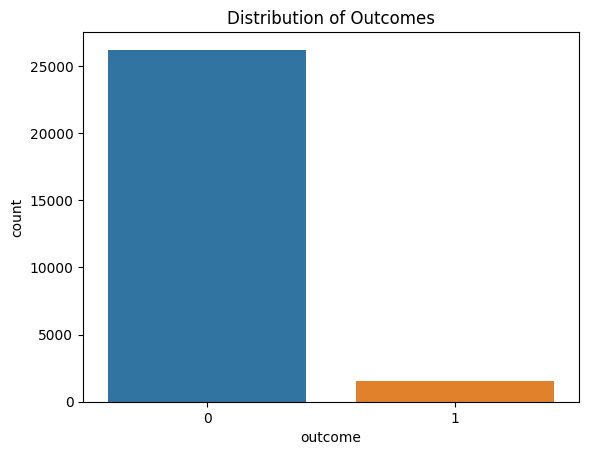

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=dataset, x='outcome')
plt.title('Distribution of Outcomes')
plt.show()

As expected, we have a lot more negative (0) cultures than positive (1) cultures! That was the reason for conducting this project in the first place, so it is good to know that this is really the case. We would like to use a deep learning model to only do blood cultures in higher risk patients, and increase the yield.

For now, it is important to note that we should make sure to use stratification based on the outcome when we create the train/test split, and that we look for ways to appropriately make these imbalanced classifications.

Next, we will look at all the other features and their distributions:

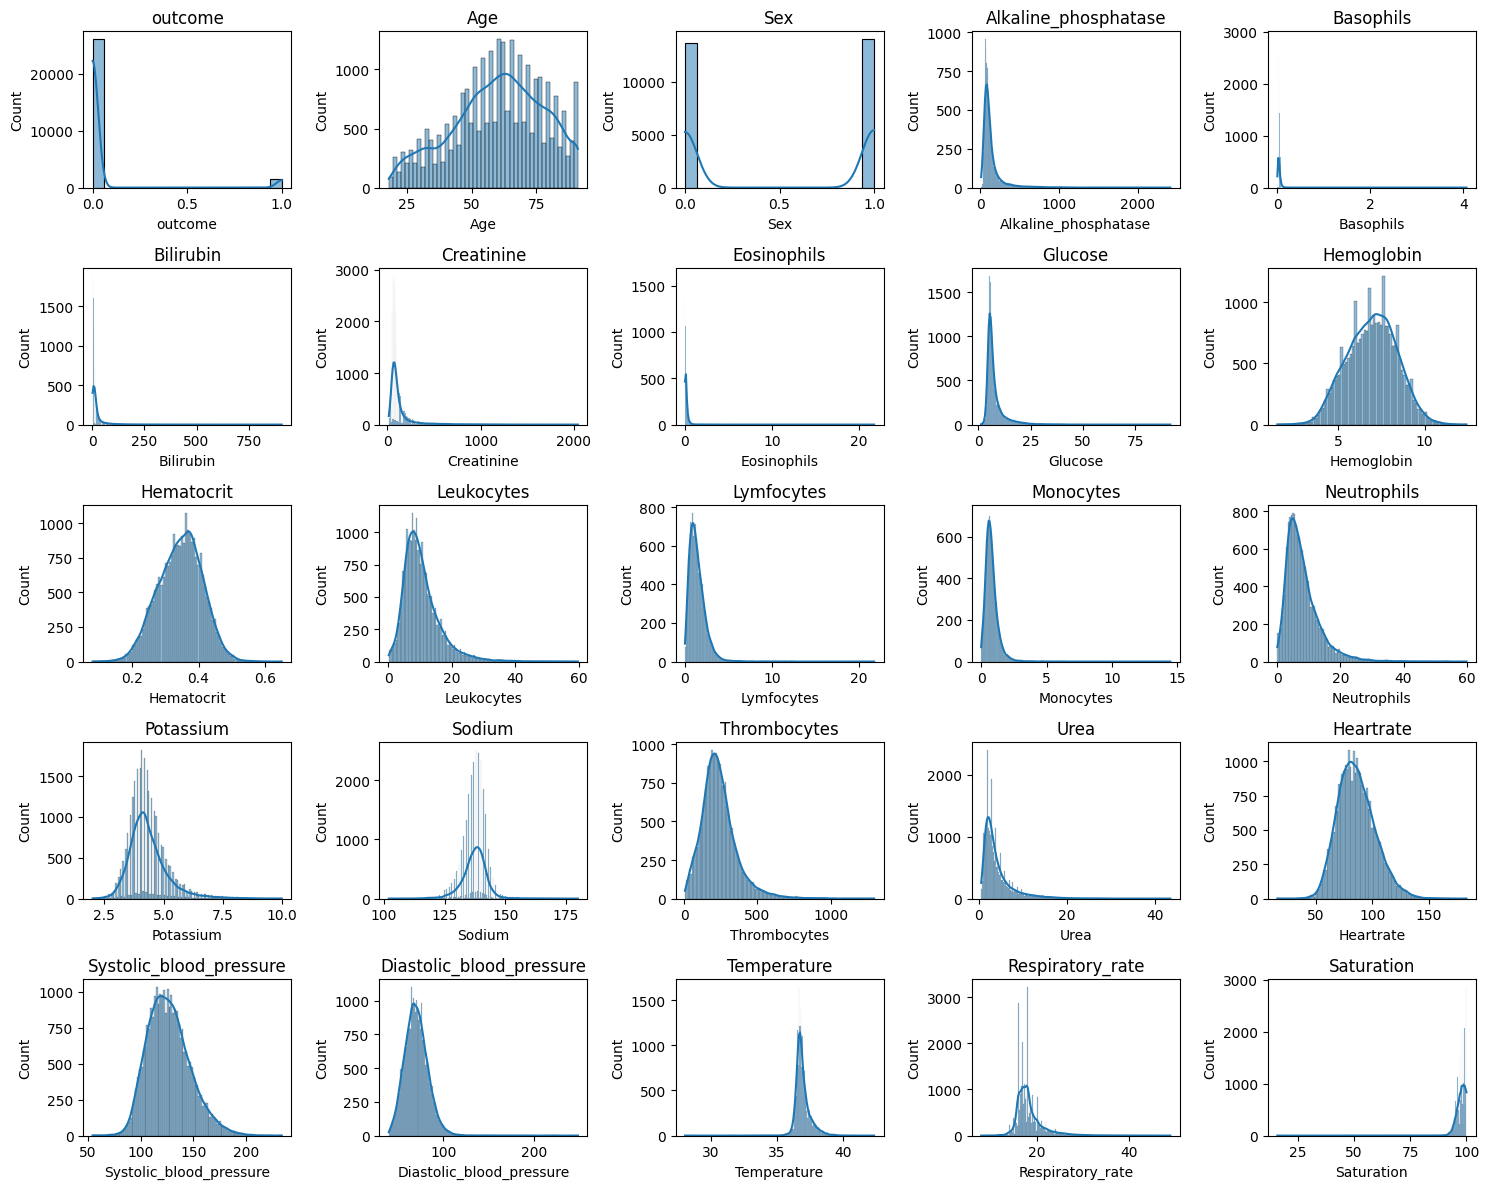

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 12))

for i, column in enumerate(dataset.columns):
    ax = axs[i // 5, i % 5]
    sns.histplot(data=dataset, x=column, kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

Overall, this looks pretty good. We have one dichotomous variable (Sex), and otherwise nicely distributed continuous variable with mostly rightly skewed distributions. This is all to be expected with medical data. One error that we can see is that the saturation variable (bottom right corner) has some values below 70%. Those value as physiologically incompatible with life, so they may be data entry errors. To err on the safe side, we will remove those values.

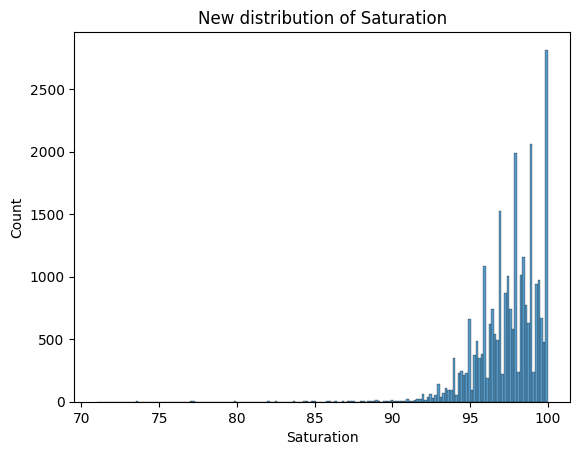

In [6]:
import numpy as np
dataset.loc[dataset['Saturation'] < 70, 'Saturation'] = np.nan

sns.histplot(data=dataset, x='Saturation')
plt.title('New distribution of Saturation')
plt.show()

That looks better. Now, let's have a look at the correlations between all the variables:

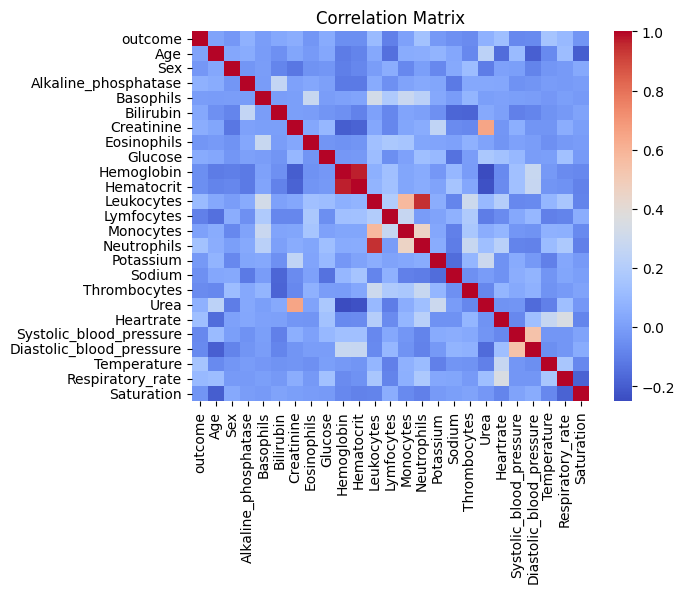

In [7]:
corr_matrix = dataset.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Overall, the heatmap shows that most correlations are within -0.2 to 0.2. Just a few of the neutrophil/lymphocyte/leukocyte counts are somewhat correlated. That makes sense, since they are counted from the same total number of cells, and tend to elevate together in case of infection. Still, it would be valuable to have all of them in there, since they tend to elevate in slightly different proportions with different infections. In the end, this heatmap does not give me any indication to clean any of the data further.

# Preprocessing

All the data are cleaned and ready for use. Now, we need to preprocess it an make the dataframe in such a form that it can be fed into the model. To make sure all modelling attempts and comparisons work the same, we will need to impute the missing data and normalize it.

In [8]:
# Impute the missing data with medians
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
imputed_data = imputer.fit_transform(dataset)
imputed_dataset = pd.DataFrame(imputed_data, columns=dataset.columns)

In [9]:
# Normalize the dataset, except for the outcome, with the standard scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(imputed_dataset.drop('outcome', axis=1))
normalized_dataset = pd.DataFrame(normalized_data, columns=imputed_dataset.columns[1:])
normalized_dataset['outcome'] = imputed_dataset['outcome']

In [10]:
normalized_dataset.head()

,Age,Sex,Alkaline_phosphatase,Basophils,Bilirubin,Creatinine,Eosinophils,Glucose,Hemoglobin,Hematocrit,Leukocytes,Lymfocytes,Monocytes,Neutrophils,Potassium,Sodium,Thrombocytes,Urea,Heartrate,Systolic_blood_pressure,Diastolic_blood_pressure,Temperature,Respiratory_rate,Saturation,outcome
0,-0.464924,0.984101,-0.022678,-0.110192,0.280342,-0.695776,-0.109898,-0.355253,1.400812,1.288469,-0.933093,-0.131003,-0.118471,-0.170096,-1.164632,0.128830,-1.415600,-0.004559,-0.431010,-0.982585,-0.795064,-0.739045,-0.800390,0.220787,0.0
1,1.647505,0.984101,-0.564139,-0.288118,-0.312445,-0.225041,-0.109898,-0.245541,-1.974134,-1.868130,1.572664,0.561965,1.512794,2.034369,0.826710,-0.871353,2.450173,-0.004559,-0.491777,-0.287671,-0.564620,1.217567,-0.460537,-0.439924,0.0
2,0.448559,0.984101,-0.190718,-0.466043,-0.175648,-0.225041,-0.412460,0.193305,0.716701,1.048118,-0.567670,-0.811814,-0.503631,-0.392006,-0.915714,-0.871353,-0.027008,-0.288806,-0.714590,0.274878,0.766835,-0.482440,0.105884,-0.605102,0.0
3,0.448559,0.984101,-0.405435,-0.110192,-0.312445,-0.225041,-0.109898,0.059213,0.488664,0.647535,-0.498066,-1.285950,-1.138011,-0.126202,-1.040173,-0.471280,-0.172724,-0.241431,-0.086664,0.437025,0.280342,0.191148,0.955517,-1.678757,0.0
4,-0.407832,0.984101,-0.190718,0.601510,-0.175648,-0.225041,-0.034258,2.192495,1.446419,1.144259,0.406791,3.260892,0.878413,-0.026221,-0.168961,-0.671316,-0.018436,-0.194057,0.588526,-0.050518,-0.120802,-0.161684,-0.271730,-0.026980,0.0


Notably, we could also have done the normalization procedure with the Normalization() function from tensorflow.keras.layers, but they will basically yield the same result. We will now split the fully imputed and normalized dataset into a training and test set, so we can keep the test set for the final validation. We will use the standard 80/20 split.

In [11]:
from sklearn.model_selection import train_test_split

X = normalized_dataset.drop('outcome', axis=1)
y = normalized_dataset['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22164 entries, 25940 to 2732
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       22164 non-null  float64
 1   Sex                       22164 non-null  float64
 2   Alkaline_phosphatase      22164 non-null  float64
 3   Basophils                 22164 non-null  float64
 4   Bilirubin                 22164 non-null  float64
 5   Creatinine                22164 non-null  float64
 6   Eosinophils               22164 non-null  float64
 7   Glucose                   22164 non-null  float64
 8   Hemoglobin                22164 non-null  float64
 9   Hematocrit                22164 non-null  float64
 10  Leukocytes                22164 non-null  float64
 11  Lymfocytes                22164 non-null  float64
 12  Monocytes                 22164 non-null  float64
 13  Neutrophils               22164 non-null  float64
 14  Potassiu

# Model architecture

With the data cleaned and preprocessed, we can now start thinking about how to set up our model. We want to create a deep learning model and would like to be able to thoroughly train the hyperparameters of it. Let's start by setting up a simple function which can create the model, but gives us the opportunity to tune it later:

In [13]:
from tensorflow import keras

def create_model(num_layers=3, num_neurons=256, dropout_rate=0.3):
    layers = [
        keras.layers.Dense(num_neurons, activation="relu", input_shape=(X_train.shape[-1],))
    ]
    
    for _ in range(num_layers - 1):
        layers.extend([
            keras.layers.Dense(num_neurons, activation="relu"),
            keras.layers.Dropout(dropout_rate)
        ])
    
    layers.append(keras.layers.Dense(1, activation="sigmoid"))
    
    model = keras.Sequential(layers)
    return model

model = create_model()
model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               6400      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 138,241


This initial structure now has three dense layes with 256 neurons. It also uses a dropout. 

Next, we will construct a flexible deep learning model using the Keras Tuner library. By defining a range of hyperparameters, such as the number of layers, neurons per layer, dropout rate, optimizer type, learning rate, and batch size, we allow the model to explore various configurations to find the one that yields the best results.

The Hyperband optimization technique is employed to balance the trade-off between exploration of new hyperparameter combinations and exploitation of promising ones, ensuring an efficient search for the optimal model. After trying other optimizers such as the BayesianOptimizer (which tended to get stuck at local minima), I found this to be the best version. 

Using early stopping with a patience of 5 and a validation split of 0.2, we try to prevent overfitting and ensure that the model generalizes well to unseen data. 

In [31]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.optimizers import legacy
import keras_tuner as kt
from tensorflow.keras.metrics import AUC


def model_builder(hp):
    num_layers = hp.Int('num_layers', min_value=2, max_value=5, step=1)
    num_neurons = hp.Int('num_neurons', min_value=128, max_value=512, step=128)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    batch_size = hp.Int('batch_size', min_value=16, max_value=64, step=16)

    optimizer = None
    if optimizer_choice == 'adam':
        optimizer = legacy.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = legacy.RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = legacy.SGD(learning_rate=learning_rate)

    model = create_model(num_layers, num_neurons, dropout_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[AUC(name='auc')])

    return model

tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('val_auc', direction='max'),
                     max_epochs=10,
                     factor=3,
                     directory='Final',
                     seed=0,
                     project_name='Hyperband Hyperparameter Search')

tuner.search(X_train, 
             y_train, 
             epochs=10, 
             validation_split=0.2, 
             callbacks=[keras.callbacks.EarlyStopping(patience=5)])


Trial 30 Complete [00h 01m 10s]
val_auc: 0.7558450698852539

Best val_auc So Far: 0.7841345071792603
Total elapsed time: 00h 17m 07s
INFO:tensorflow:Oracle triggered exit


The hyperparameter tuner conducted 3 trials, evaluated many versions of the model, and came up with a final set of most succesful parameters. Let's have a look at the final parameters we have ended up with:

In [24]:
# Retrieve the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

hp_dict = {}
for hp in best_hp.space:
    name = hp.name
    value = best_hp.get(name)
    hp_dict[name] = [value]
    
df_hp = pd.DataFrame(hp_dict)

print(df_hp)

   num_layers  num_neurons  dropout_rate optimizer  learning_rate  batch_size
0           4          384           0.4      adam       0.001262          16


After completing the hyperparameter tuning process, we examine the best hyperparameters found by the Keras Tuner. The results indicate that the optimal model configuration consists of 4 layers, 384 neurons per layer, a dropout rate of 0.4, the Adam optimizer with a learning rate of roughly 0.001, and a batch size of 16.

These hyperparameters suggest that a moderately deep architecture with a high number of neurons per layer and a significant dropout rate is best suited for the problem at hand. The use of the Adam optimizer with a relatively small learning rate ensures stable and efficient training. Additionally, a smaller batch size of 16 allows for faster convergence and improved generalization. Since the lowest learning rate and batch size were chosen, we do need to worry about potential overfitting issues.

Let's now train the best parameters with the training data:

In [32]:
# Build the best model
model_deep = tuner.hypermodel.build(best_hp)

# Train the best model on the training data
history = model_deep.fit(X_train, 
                         y_train, 
                         epochs=10, 
                         validation_split=0.2)

# Print a summary of the best model
model_deep.summary()

Epoch 1/10
555/555 [==============================] - 11s 18ms/step - loss: 0.2087 - auc: 0.7179 - val_loss: 0.1852 - val_auc: 0.7658
Epoch 2/10
555/555 [==============================] - 8s 14ms/step - loss: 0.1870 - auc: 0.7684 - val_loss: 0.1803 - val_auc: 0.7722
Epoch 3/10
555/555 [==============================] - 8s 14ms/step - loss: 0.1826 - auc: 0.7820 - val_loss: 0.1867 - val_auc: 0.7555
Epoch 4/10
555/555 [==============================] - 8s 14ms/step - loss: 0.1797 - auc: 0.7888 - val_loss: 0.1805 - val_auc: 0.7797
Epoch 5/10
555/555 [==============================] - 8s 14ms/step - loss: 0.1767 - auc: 0.8021 - val_loss: 0.1920 - val_auc: 0.7575
Epoch 6/10
555/555 [==============================] - 7s 13ms/step - loss: 0.1762 - auc: 0.8000 - val_loss: 0.1847 - val_auc: 0.7594
Epoch 7/10
555/555 [==============================] - 7s 13ms/step - loss: 0.1735 - auc: 0.8133 - val_loss: 0.1888 - val_auc: 0.7558
Epoch 8/10
555/555 [==============================] - 7s 13ms/step -

Everything is set and trained optimally. The structure is once more visualized and is different from the initial version before tuning. Now, as a comparison, we create XGBoost and Random Forest models as alternative machine learning approaches to compare with our deep learning model. Both XGBoost and Random Forest are well-known, powerful ensemble methods that have been widely used in various applications, making them suitable benchmarks for comparison.

By performing a grid search over a range of hyperparameters, we aim to find the best-performing configurations for each model. This ensures that we compare the deep learning model with optimized versions of XGBoost and Random Forest, providing a fair assessment of their capabilities.

Comparing these models can help us understand the strengths and weaknesses of different approaches for the problem at hand. This can offer valuable insights into which method is more suitable and whether the added complexity of a deep learning model is justified by its performance.

In [18]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Define the hyperparameter search spaces
param_grid_xgb = {
    "learning_rate": [0.01, 0.05, 0.1],
    "min_child_weight": [1, 2, 3],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1]
}

param_grid_rf = {
    "min_samples_leaf": [1, 2, 3],
    "min_samples_split": [2, 4, 6],
    "max_depth": [3, 5, 7],
}

# Instantiate the algorithms and set up the cross validation steps
xgb = XGBClassifier(n_estimators=100)
rf = RandomForestClassifier(n_estimators=100)
crossval = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Perform grid search and get the best estimators
model_xgb = GridSearchCV(xgb, param_grid_xgb, cv=crossval, n_jobs=-1).fit(X_train, y_train).best_estimator_
model_rf = GridSearchCV(rf, param_grid_rf, cv=crossval, n_jobs=-1).fit(X_train, y_train).best_estimator_

# Print the best hyperparameters for each model
print("Best hyperparameters for XGBClassifier:", model_xgb.get_params())
print("Best hyperparameters for RandomForestClassifier:", model_rf.get_params())

Best hyperparameters for XGBClassifier: {'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Best hyperparameters for RandomForestClassifier

We have trained both a random forest model and an xgboost model to compare with the deep learning model. Let's see how they do in the results section!

## Results and analysis

## The Area Under the Curve
Now, we will evaluate and compare the performance of our deep learning model against the XGBoost and Random Forest models. The first result we will examine is the comparison of the Area Under the Curve (AUC) for the Receiver Operating Characteristic (ROC) curves. The AUC-ROC curve is a popular metric for evaluating the performance of classification models, as it considers both the true positive rate and the false positive rate. It is especially meaningful in situations with large class imbalances such as we have, since the accuracy metric becomes largely meaningless in those settings. By plotting the ROC curves for all three models on the training and testing sets, we can visualize and compare their ability to distinguish between the positive and negative classes.

174/174 [==============================] - 0s 3ms/step


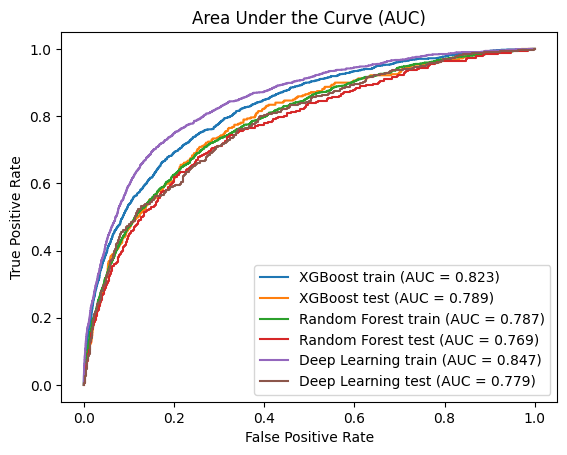

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(model, X_train, y_train, X_test, y_test, model_name):
    # predicted probabilities
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]

    # AUC scores
    train_auc = roc_auc_score(y_train, train_probs)
    test_auc = roc_auc_score(y_test, test_probs)

    # ROC curves
    train_fpr, train_tpr, _ = roc_curve(y_train, train_probs)
    test_fpr, test_tpr, _ = roc_curve(y_test, test_probs)

    # plotting
    plt.plot(train_fpr, train_tpr, label=(f"{model_name} train (AUC = {train_auc:.3f})"))
    plt.plot(test_fpr, test_tpr, label=(f"{model_name} test (AUC = {test_auc:.3f})"))

# Plot ROC curves for XGBoost and Random Forest models
plot_roc_curve(model_xgb, X_train, y_train, X_test, y_test, "XGBoost")
plot_roc_curve(model_rf, X_train, y_train, X_test, y_test, "Random Forest")

# Deep learning model AUC scores and ROC curves
deep_probs_train = model_deep.predict(X_train)
deep_probs_test = model_deep.predict(X_test)
deep_auc_train = roc_auc_score(y_train, deep_probs_train)
deep_auc_test = roc_auc_score(y_test, deep_probs_test)
deep_fpr_train, deep_tpr_train, _ = roc_curve(y_train, deep_probs_train)
deep_fpr_test, deep_tpr_test, _ = roc_curve(y_test, deep_probs_test)

plt.plot(deep_fpr_train, deep_tpr_train, label=("Deep Learning train (AUC = %.3f)" % (deep_auc_train)))
plt.plot(deep_fpr_test, deep_tpr_test, label=("Deep Learning test (AUC = %.3f)" % (deep_auc_test)))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the Curve (AUC)")
plt.legend()
plt.show()


The results reveal varying performance across the three models. The deep learning model achieves the highest AUC score on the training set (0.847), suggesting it has captured the underlying patterns effectively. However, its performance drops to an AUC of 0.779 on the test set, which might indicate significant overfitting to the training data.

In contrast, the XGBoost model shows a more consistent performance, with an AUC of 0.823 on the training set and 0.789 on the test set. It outperforms the deep learning model on the test set, suggesting better generalization to unseen data.

The Random Forest model has the lowest overall performance, with an AUC of 0.787 on the training set and 0.769 on the test set, indicating it might be less suitable for this particular problem.

In summary, although the deep learning model demonstrates strong performance on the training data, it is overfitting, resulting in a lower AUC on the test set compared to the XGBoost model. This highlights the importance of considering model complexity and generalization when selecting the most appropriate approach for a given problem. I had fully expected the deep learning model to perform better in both the training and the test set!

## Further exploration: the AUPRC
The next metric we will examine is the Area Under the Precision-Recall Curve (AUPRC). This metric is particularly useful when dealing with imbalanced datasets, as it focuses on the positive class (i.e., the minority class) by considering both precision and recall. Precision measures the proportion of true positives out of the predicted positives, while recall (sensitivity) quantifies the proportion of true positives out of all actual positive instances.

The AUPRC provides a comprehensive view of the trade-off between precision and recall, which is valuable for understanding a model's ability to correctly identify the minority class while minimizing false positives. By comparing the AUPRC for our deep learning, XGBoost, and Random Forest models, we can gain further insights into their performance and suitability for tackling the problem at hand.

174/174 [==============================] - 0s 3ms/step


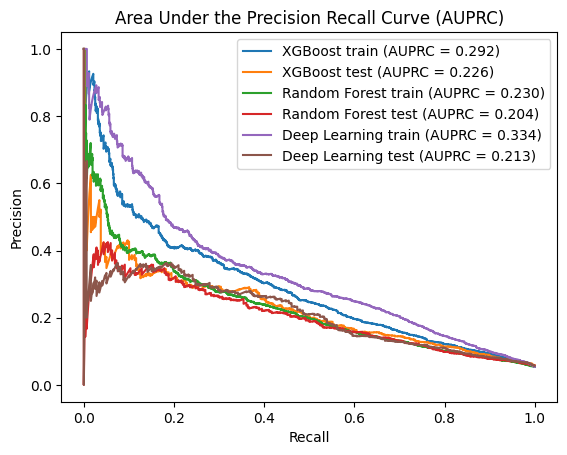

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve

def plot_auprc_curve(model, X_train, y_train, X_test, y_test, model_name, is_deep_learning=False):
    # predicted probabilities
    if is_deep_learning:
        train_probs = model.predict(X_train)
        test_probs = model.predict(X_test)
    else:
        train_probs = model.predict_proba(X_train)[:, 1]
        test_probs = model.predict_proba(X_test)[:, 1]

    # AUPRC scores
    train_auprc = average_precision_score(y_train, train_probs)
    test_auprc = average_precision_score(y_test, test_probs)

    # PR curves
    train_precision, train_recall, _ = precision_recall_curve(y_train, train_probs)
    test_precision, test_recall, _ = precision_recall_curve(y_test, test_probs)

    # plotting
    plt.plot(train_recall, train_precision, label=(f"{model_name} train (AUPRC = {train_auprc:.3f})"))
    plt.plot(test_recall, test_precision, label=(f"{model_name} test (AUPRC = {test_auprc:.3f})"))

# Plot AUPRC curves for XGBoost and Random Forest models
plot_auprc_curve(model_xgb, X_train, y_train, X_test, y_test, "XGBoost")
plot_auprc_curve(model_rf, X_train, y_train, X_test, y_test, "Random Forest")

# Deep learning model AUPRC scores and PR curves
plot_auprc_curve(model_deep, X_train, y_train, X_test, y_test, "Deep Learning", is_deep_learning=True)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Area Under the Precision Recall Curve (AUPRC)")
plt.legend()
plt.show()


The AUPRC results provide additional insights into the performance of our models, particularly regarding the handling of the minority class. The deep learning model achieves an AUPRC of 0.334 on the training set but drops to 0.213 on the test set, indicating that the model may be overfitting and struggling to generalize well to unseen data.

The XGBoost model demonstrates more consistent performance, with an AUPRC of 0.292 on the training set and 0.226 on the test set. This suggests that XGBoost is better at maintaining its ability to identify the minority class while minimizing false positives in the test data.

The Random Forest model performs significantly worse than the other two models, confirming its limitations in handling this specific problem.

Comparing the AUPRC results with the AUC results, we can see a similar pattern. The deep learning model exhibits the highest performance on the training data but is surpassed by the XGBoost model on the test data, while the Random Forest model underperforms in both metrics. These findings emphasize the importance of considering multiple evaluation metrics to obtain a comprehensive understanding of model performance, especially in the context of imbalanced datasets.

We can appreciate that if we want to have a fairly high recall/sensitivity (which we want, since we do not want to miss positive blood cultures), we do have to accept a fairly low precision of about 0.2 regardless of the model we use. This means that even with the model, the yield of our blood cultures could only increase to about 20%. Still, that is much better than the current standard of around 5%. 

## A final insight: the Calibration Curve
The final metric we will explore is the calibration curve, which assesses the reliability of the predicted probabilities generated by a classification model. In a well-calibrated model, the predicted probabilities should match the true probabilities of the corresponding outcomes, meaning that the model's confidence in its predictions is accurate.

Examining the calibration curves will allow us to evaluate whether the models are overconfident or underconfident in their predictions, which can inform potential adjustments or recalibration techniques to improve their reliability. In conjunction with the other metrics we have analyzed (AUC and AUPRC), the calibration curve offers a more comprehensive understanding of the performance and applicability of the models for our problem.

174/174 [==============================] - 0s 2ms/step


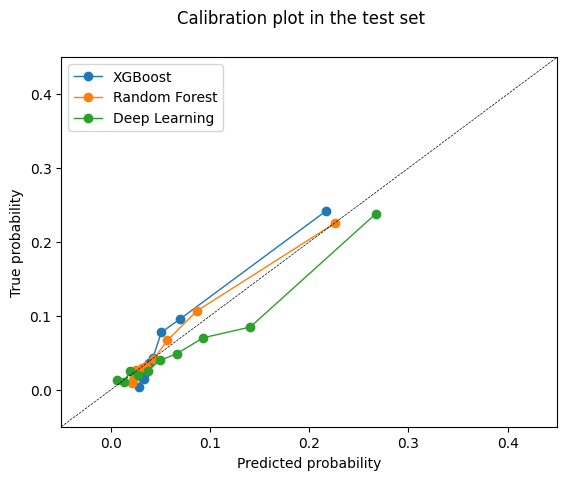

In [28]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

def plot_calibration_curve(model, X_test, y_test, model_name, is_deep_learning=False):
    if not is_deep_learning:
        # Calibrate the probabilities for the model
        calibrator = CalibratedClassifierCV(model, cv='prefit', method='sigmoid')
        calibrator.fit(X_test, y_test)
        test_probs_calibrated = calibrator.predict_proba(X_test)[:, 1]
    else:
        test_probs_calibrated = model.predict(X_test).ravel()

    # Get the calibration curve
    y_true, y_pred = calibration_curve(y_test, test_probs_calibrated, n_bins=10, strategy="quantile")

    # Plot the calibration curve
    plt.plot(y_pred, y_true, marker="o", linewidth=1, label=model_name)

# Create the calibration plot
fig, ax = plt.subplots()

plot_calibration_curve(model_xgb, X_test, y_test, "XGBoost")
plot_calibration_curve(model_rf, X_test, y_test, "Random Forest")
plot_calibration_curve(model_deep, X_test, y_test, "Deep Learning", is_deep_learning=True)

line = mlines.Line2D([0, 1], [0, 1], color="black", linewidth=0.5, linestyle="--")
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle("Calibration plot in the test set")
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability")
ax.set(xlim=[-0.05, 0.45], ylim=[-0.05, 0.45])
plt.legend()
plt.show()


Overall, all the lines are quite close to the diagonal, indicating the models are fairly well-calibrated, despite the class imbalances. The calibration curve results reveal slight patterns in the reliability of the predicted probabilities for each model. Both the XGBoost and RandomForest models exhibit curves that are slightly above the diagonal, suggesting that they tend to be slightly underconfident in their predictions. In contrast, the deep learning model's curve is slightly below the diagonal, indicating a tendency to be somewhat overconfident in its predictions.
Furthermore, we can appreciate that most of the probabilities are really low. Even the 10% highest probabilities are only just above 20%. This means that is extremely hard to find patients with a very high chance of a positive blood culture.

# Discussions and conclusion

For this final project in the DTSA-5511 course, I have created a deep learning model to predict the outcomes of blood cultures in the emergency department, and compared it to XGBoost and Random Forest models. If we use the model to withhold testing in very low risk patients, we may be able to reduce costs, antibiotic treatments, and hospital length-of-stay. We used data from the Beth Israel Deaconess Medical Center in Boston and used regular laboratory values and vitals sign measurements that would be available in the ED for most patients. 

While we initially expected the deep learning model to outperform the other models, our results demonstrated that the XGBoost model generalized better. The deep learning model's suboptimal generalizability could be attributed to several factors, despite employing hyperparameter tuning with a robust search method like Hyperband. Although the hyperparameter tuning process led us to a specific configuration with 4 layers, 384 neurons per layer, a dropout rate of 0.4, and the Adam optimizer with a learning rate of roughly 0.001, it is possible that the search space did not include the best set of hyperparameters for this particular problem. The chosen architecture, dropout rate, and optimizer might not have been ideal for capturing the underlying patterns in the data, resulting in overfitting and reduced performance on the test set.

To improve the model's generalizability in the future, we could revisit the hyperparameter tuning process by expanding the search space or exploring other search strategies. For instance, we could investigate a broader range of layer configurations or consider more advanced layer types, such as convolutional or recurrent layers. We could also assess the impact of additional regularization techniques beyond dropout, like L1 or L2 regularization. Furthermore, we could experiment with a wider range of learning rates, optimizers, and batch sizes to identify more effective combinations.

In conclusion, the deep learning model did not surpass the XGBoost model as initially anticipated, but it still showed potential for further improvement because of the superiority in the training data. By refining the hyperparameter tuning process and incorporating a more comprehensive search space, we can better understand the model's strengths and weaknesses and work toward enhancing its performance in the clinical context.

I have learned many new aspects of deep learning through this course. I have integrated these aspects into the blood culture prediction model in this project and have a better understanding of how certain phenomena (such as the drop in performance between train/test) develop and can be tackled. I look forward to learning even more in this space.

The notebook for this project can be found at: https://github.com/michielschinkel/Deep-Learning